# Please use google colab and T4 GPU ENV

In [ ]:
!pip install \
    --extra-index-url=https://pypi.nvidia.com \
    cudf-cu12==23.12.* cuml-cu12==23.12.* cugraph-cu12==23.12.* \
    cuspatial-cu12==23.12.* cuproj-cu12==23.12.*

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 955.2/955.2 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 889.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 92.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 582.4/582.4 kB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import cudf, cuml, cugraph, cuspatial, cudf

In [ ]:
cudf.__version__

'23.12.01'

In [ ]:
import numpy as np
from cuml import RandomForestClassifier as RandomForestClassifierGPU
import cupy as cp
from sklearn.ensemble import RandomForestClassifier
import time
import pandas as pd
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
import nltk
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
data=pd.read_csv('spam.csv')
data

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
data.isna().sum()

Category    0
Message     0
dtype: int64

In [ ]:
data.columns

Index(['Category', 'Message'], dtype='object')

In [ ]:
data['Spam']=data['Category'].apply(lambda x:1 if x=='spam' else 0)
data.head(5)

,Category,Message,Spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [ ]:
nltk.download('stopwords')
tokenizer = RegexpTokenizer('\w+')
sw = set(stopwords.words('english'))
ps = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def getStem(review):
    review = review.lower()
    tokens = tokenizer.tokenize(review) # breaking into small words
    removed_stopwords = [w for w in tokens if w not in sw]
    stemmed_words = [ps.stem(token) for token in removed_stopwords]
    clean_review = ' '.join(stemmed_words)
    return clean_review

def getDoc(document):
  d = []
  for doc in document:
      d.append(getStem(doc))
  return d

In [ ]:
data2 = data.to_numpy()
X2 = data2[:, 1]

In [ ]:
stemmed_doc = getDoc(X2)
stemmed_doc[:10]

['go jurong point crazi avail bugi n great world la e buffet cine got amor wat',
 'ok lar joke wif u oni',
 'free entri 2 wkli comp win fa cup final tkt 21st may 2005 text fa 87121 receiv entri question std txt rate c appli 08452810075over18',
 'u dun say earli hor u c alreadi say',
 'nah think goe usf live around though',
 'freemsg hey darl 3 week word back like fun still tb ok xxx std chg send 1 50 rcv',
 'even brother like speak treat like aid patent',
 'per request mell mell oru minnaminungint nurungu vettam set callertun caller press 9 copi friend callertun',
 'winner valu network custom select receivea 900 prize reward claim call 09061701461 claim code kl341 valid 12 hour',
 'mobil 11 month u r entitl updat latest colour mobil camera free call mobil updat co free 08002986030']

In [ ]:
cv = CountVectorizer()
vc = cv.fit_transform(stemmed_doc)
print(type(vc))
X2 = vc.todense()
print(type(X2))
print(X2[0])

<class 'scipy.sparse._csr.csr_matrix'>
<class 'numpy.matrix'>
[[0 0 0 ... 0 0 0]]


In [ ]:
print(X2.shape)

(5572, 7248)


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X2,data.Spam,test_size=0.25)

In [ ]:
#X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
print(X_train)
print(y_train)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[0 0 0 ... 0 0 0]


In [ ]:
X_train.shape

(4179, 7248)

In [ ]:
X_train= X_train.astype(float)
y_train= y_train.astype(float)

X_gpu = cp.array(X_train)
y_gpu = cp.array(y_train)

In [ ]:
clf = RandomForestClassifierGPU()
start_time = time.time()
clf.fit(X_gpu, y_gpu)
end_time = time.time()
time_taken_gpu = end_time-start_time
y_test_predicted = clf.predict(X_test)

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


In [ ]:
time_taken_gpu = end_time-start_time

In [ ]:
y_test_predicted = clf.predict(X_test)
print(X_test[0])
print(y_test_predicted[0])

[[0 0 0 ... 0 0 0]]
0.0


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
import joblib


The accuracy score is  94.18521177315147 %


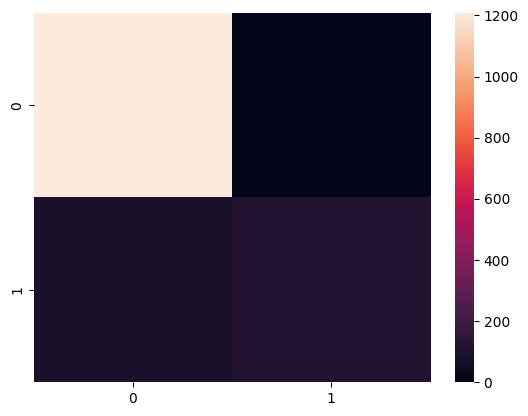

In [ ]:
## Print metrics
accuracy = metrics.accuracy_score(y_test,y_test_predicted)
confusion_matrix = metrics.confusion_matrix(y_test,y_test_predicted)
print('The accuracy score is ',accuracy*100,'%')
sns.heatmap(confusion_matrix)
plt.show()

In [ ]:
def prepare(messages):
    d = getDoc(messages)
    # dont do fit_transform!! it will create new vocab.
    print(d)
    return cv.transform(d)

In [ ]:
messages = prepare(["Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"])
print(type(messages))
X3 = messages.todense()
print(type(X3))
# X3 = X3.astype(float)
print(X3)
print(X3.shape)
X_gpu = cp.array(X3)
y_pred = clf.predict(X_gpu)
print(y_pred[0])

['free entri 2 wkli comp win fa cup final tkt 21st may 2005 text fa 87121 receiv entri question std txt rate c appli 08452810075over18']
<class 'scipy.sparse._csr.csr_matrix'>
<class 'numpy.matrix'>
[[0 0 0 ... 0 0 0]]
(1, 7248)
1.0


In [ ]:
#Save model
#joblib.dump(clf, 'model.txt')

In [ ]:
#import pickle
#pickle.dump(clf, open('model_GPU.pkl', 'wb'))